# Enhancing Emotion Recognition Using POS Tagging 
**Assignment 1** <br>
**Name**: Pola Gnana Shekar <br>
**Roll No**: 21CS10052 <br>

## POS Tagger Implementation
In this task we create a POS tagger used in upcoming tasks to add the POS tags to the sentences.
- A POS tagger is implemented from scratch using Viterbi algorithm and NLTK corpus.
- It involves calculating transition and emission probabilities based on tagged sentences.

In [1]:
# Importing Libraries
import nltk
from nltk.corpus import treebank
from collections import defaultdict
import numpy as np

# Downloading necessary NLTK corpora
nltk.download('treebank')
nltk.download('punkt')

[nltk_data] Downloading package treebank to /usr/share/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Task 1: POS Tagger Class Implementation
Implementation of class used to perform POS tagging for a sentence. Here are the functionlaties (methods) defined in the class:

- **`__init__`**: Initializes the POS tagger with dictionaries to store transition probabilities, emission probabilities, tag counts, and word counts.
- **`train`**: Trains the POS tagger using tagged sentences by calculating transition and emission probabilities. It normalizes these probabilities to convert counts into probabilities.
- **`viterbi`** : Implements the Viterbi algorithm to find the most probable sequence of POS tags for a given list of words. It initializes base cases for the first word and iterates through the sentence to build the best path for each word.

In [2]:
class POSTagger:
    def __init__(self):
        # Initialize dictionaries to hold probabilities and counts
        self.transition_probs = defaultdict(lambda: defaultdict(float))
        self.emission_probs = defaultdict(lambda: defaultdict(float))
        self.tag_counts = defaultdict(float)
        self.word_counts = defaultdict(float)
        
    def train(self, tagged_sentences):
        # Train the model by calculating transition and emission probabilities
        for sentence in tagged_sentences:
            prev_tag = "<s>"
            for word, tag in sentence:
                self.tag_counts[tag] += 1
                self.word_counts[word] += 1
                self.transition_probs[prev_tag][tag] += 1
                self.emission_probs[tag][word] += 1
                prev_tag = tag
        
        # Normalize the transition probabilities
        for prev_tag, transitions in self.transition_probs.items():
            total = sum(transitions.values())
            for tag in transitions:
                self.transition_probs[prev_tag][tag] /= total
                
        # Normalize the emission probabilities
        for tag, emissions in self.emission_probs.items():
            total = sum(emissions.values())
            for word in emissions:
                self.emission_probs[tag][word] /= total
    def viterbi(self, words):
        V = [{}]
        path = {}
        
        # Initialize base cases (t = 0)
        for tag in self.tag_counts:
            if words[0] in self.emission_probs[tag]:
                V[0][tag] = self.transition_probs["<s>"].get(tag, 0) * self.emission_probs[tag][words[0]]
            else:
                V[0][tag] = self.transition_probs["<s>"].get(tag, 0) * (1 / (self.word_counts[tag] + len(self.word_counts)))
            path[tag] = [tag]
        
        # Run Viterbi for t > 0
        for t in range(1, len(words)):
            V.append({})
            new_path = {}
            
            for tag in self.tag_counts:
                max_prob, prev_state = max(
                    ((V[t-1][prev_tag] * self.transition_probs[prev_tag].get(tag, 0) * self.emission_probs[tag].get(words[t], 1 / (self.word_counts[tag] + len(self.word_counts)))), prev_tag)
                    for prev_tag in self.tag_counts
                )
                V[t][tag] = max_prob
                new_path[tag] = path[prev_state] + [tag]
            path = new_path
            
        # Return the most probable tag sequence
        max_prob, final_state = max((V[-1][tag], tag) for tag in self.tag_counts)
        return path[final_state]

In [3]:
# Train the POS tagger using the treebank dataset
treebank_sents = treebank.tagged_sents()

pos_tagger = POSTagger()
pos_tagger.train(treebank_sents)

In [4]:
# Test the POS tagger on a sample sentence
test_sentence = "The love to be with him"
test_words = test_sentence.split()
predicted_tags = pos_tagger.viterbi(test_words)

print(f"Sentence: {test_sentence}")
print(f"Predicted POS tags: {predicted_tags}")

Sentence: The love to be with him
Predicted POS tags: ['DT', 'NN', 'TO', 'VB', 'IN', 'PRP']


##  Task 2: Vanilla Emotion Recognizer
This task serves as a baseline for emotion recognition, setting the stage for further enhancements in the next task.
- A Vanilla Emotion Recognizer is built using Naive Bayes and SVM classifiers. 
- Creating TF-IDF embeddings to represent the text data numerically. 

In [5]:
# Download and Prepare the Dataset
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion", "split")

train_data = dataset["train"]
val_data = dataset["validation"]
test_data = dataset["test"]

print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 16000
Number of validation samples: 2000
Number of test samples: 2000


This cell performs hyperparameter optimization for the max_features parameter in the TfidfVectorizer. It loops through a predefined set of max_features values, trains a model on the training data, and evaluates it on the validation set. 

In [6]:
# Hyperparameter Optimization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score

# Extract texts and labels from the dataset
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# Define a range of values for max_features to test
max_features_options = [100, 200, 500, 1000,1250, 1500, 2000, 3000, 5000]

best_accuracy_NB = 0
best_max_features_NB = 0
best_model_NB = None

best_accuracy_SVM = 0
best_max_features_SVM = 0
best_model_SVM = None

In [7]:
# Loop through each max_features option for Naive Bayes
for max_features in max_features_options:
    vectorizer = TfidfVectorizer(max_features=max_features)
    
    # Transform the text data
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts)
    
    # Train the Naive Bayes model
    nb_model = MultinomialNB()
    nb_model.fit(X_train, train_labels)
    y_val_pred_nb = nb_model.predict(X_val)
    val_accuracy = accuracy_score(val_labels, y_val_pred_nb)
    
    print(f"Validation Accuracy with max_features={max_features}: {val_accuracy}")
    
    # Check if this is the best model so far
    if val_accuracy > best_accuracy_NB:
        best_accuracy_NB = val_accuracy
        best_max_features_NB = max_features
        best_model_NB = nb_model

print(f"Best max_features value: {best_max_features_NB} with Validation Accuracy: {best_accuracy_NB}")

Validation Accuracy with max_features=100: 0.375
Validation Accuracy with max_features=200: 0.387
Validation Accuracy with max_features=500: 0.5355
Validation Accuracy with max_features=1000: 0.778
Validation Accuracy with max_features=1250: 0.7835
Validation Accuracy with max_features=1500: 0.7785
Validation Accuracy with max_features=2000: 0.769
Validation Accuracy with max_features=3000: 0.7425
Validation Accuracy with max_features=5000: 0.701
Best max_features value: 1250 with Validation Accuracy: 0.7835


In [8]:
# Loop through each max_features option for SVM
for max_features in max_features_options:
    vectorizer = TfidfVectorizer(max_features=max_features)
    
    # Transform the text data
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts)
    
    # Train the SVM model
    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train, train_labels)
    y_val_pred_svm = svm_model.predict(X_val)
    val_accuracy = accuracy_score(val_labels, y_val_pred_svm)
    
    print(f"Validation Accuracy with max_features={max_features}: {val_accuracy}")
    
    # Check if this is the best model so far
    if val_accuracy > best_accuracy_SVM:
        best_accuracy_SVM = val_accuracy
        best_max_features_SVM = max_features
        best_model_SVM = svm_model

print(f"Best max_features value: {best_max_features_SVM} with Validation Accuracy: {best_accuracy_SVM}")

Validation Accuracy with max_features=100: 0.369
Validation Accuracy with max_features=200: 0.3825
Validation Accuracy with max_features=500: 0.5555
Validation Accuracy with max_features=1000: 0.8455
Validation Accuracy with max_features=1250: 0.868
Validation Accuracy with max_features=1500: 0.87
Validation Accuracy with max_features=2000: 0.886
Validation Accuracy with max_features=3000: 0.887
Validation Accuracy with max_features=5000: 0.8875
Best max_features value: 5000 with Validation Accuracy: 0.8875


In [9]:
# Evaluate on the Test Set
# Using the best max_features, transform the test set
vectorizer_NB = TfidfVectorizer(max_features=best_max_features_NB)
vectorizer_SVM = TfidfVectorizer(max_features=best_max_features_SVM)

X_train_NB = vectorizer_NB.fit_transform(train_texts)
X_test_NB = vectorizer_NB.transform(test_texts)
X_train_SVM = vectorizer_SVM.fit_transform(train_texts)
X_test_SVM = vectorizer_SVM.transform(test_texts)

# Train the best model on the entire training data
best_model_NB.fit(X_train_NB, train_labels)
y_test_pred_nb = best_model_NB.predict(X_test_NB)

best_model_SVM.fit(X_train_SVM, train_labels)
y_test_pred_svm = best_model_SVM.predict(X_test_SVM)

# Print test accuracy
test_accuracy_NB = accuracy_score(test_labels, y_test_pred_nb)
print(f"Test Accuracy Naive Bayes : {test_accuracy_NB}")

test_accuracy_SVM = accuracy_score(test_labels, y_test_pred_svm)
print(f"Test Accuracy SVM : {test_accuracy_SVM}")

Test Accuracy Naive Bayes : 0.7875
Test Accuracy SVM : 0.887


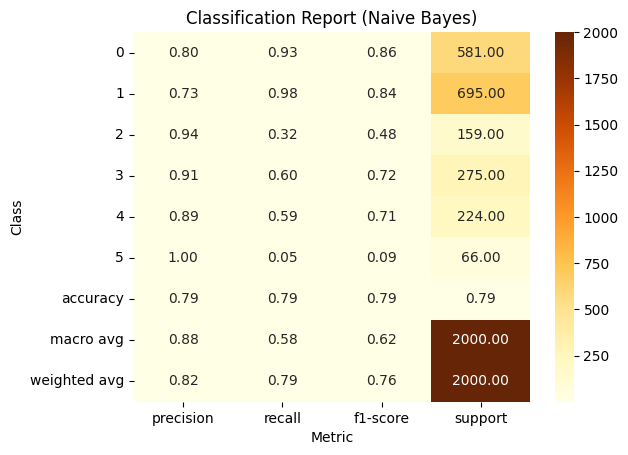

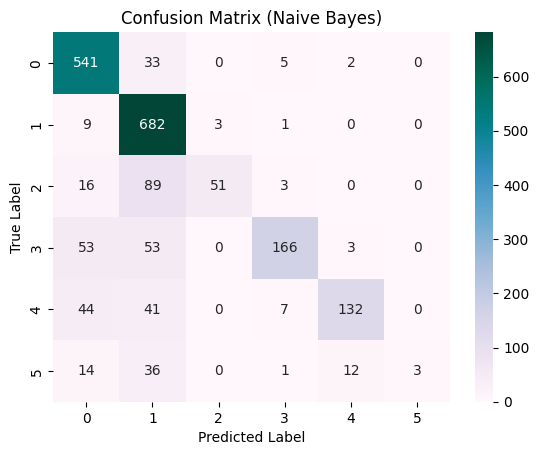

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a classification report
class_report_nb = classification_report(test_labels, y_test_pred_nb, output_dict=True)

# Convert the report to a DataFrame for better visualization
class_report_df_nb = pd.DataFrame(class_report_nb).transpose()

# Visualize the classification report
sns.heatmap(class_report_df_nb, annot=True, cmap="YlOrBr", fmt=".2f")
plt.title("Classification Report (Naive Bayes)")
plt.xlabel("Metric")
plt.ylabel("Class")
plt.show()

# Create a confusion matrix
conf_matrix_nb = confusion_matrix(test_labels, y_test_pred_nb)

# Visualize the confusion matrix
sns.heatmap(conf_matrix_nb, annot=True, cmap="PuBuGn", fmt="d")
plt.title("Confusion Matrix (Naive Bayes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

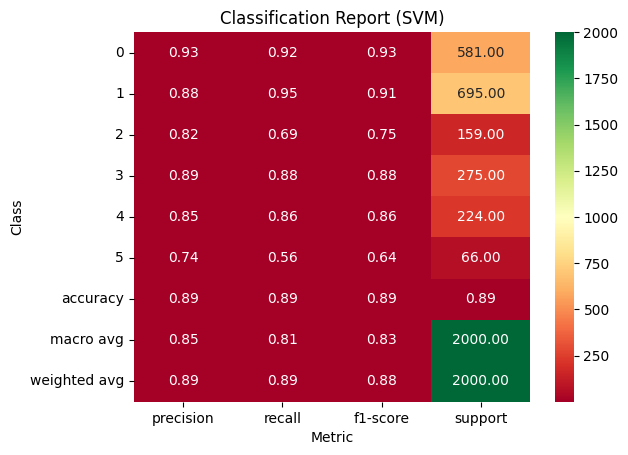

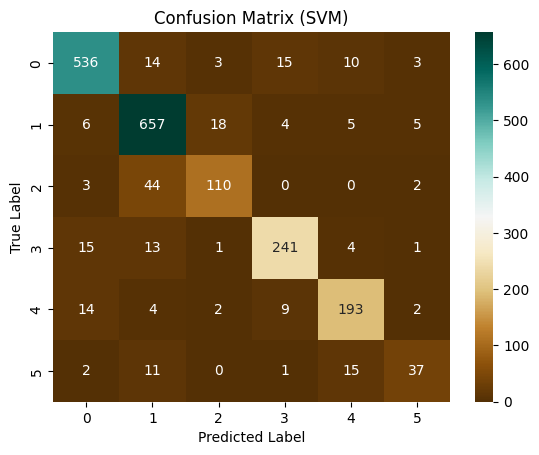

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a classification report
class_report_svm = classification_report(test_labels, y_test_pred_svm, output_dict=True)

# Convert the report to a DataFrame for better visualization
class_report_df_svm = pd.DataFrame(class_report_svm).transpose()

# Visualize the classification report
sns.heatmap(class_report_df_svm, annot=True, cmap="RdYlGn", fmt=".2f")
plt.title("Classification Report (SVM)")
plt.xlabel("Metric")
plt.ylabel("Class")
plt.show()

# Create a confusion matrix
conf_matrix_svm = confusion_matrix(test_labels, y_test_pred_svm)

# Visualize the confusion matrix
sns.heatmap(conf_matrix_svm, annot=True, cmap="BrBG", fmt="d")
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Improved Emotion Recognizer
This task aims to improve the emotion recognition model by incorporating Part-of-Speech (POS) tags as features.
- Leverage the POS tagger trained in Task 1 and integrate it into a machine learning pipeline. 
- The pipeline will extract TF-IDF features from both the original text and the concatenated text-POS tag combinations.
- Train the same classifier on the new features and evaluate its performance on the validation and test sets. 
- Visualize the classification report and confusion matrix for the final model.

In [12]:
# Define a function to apply the custom POS tagger with progress bar
def pos_tag_texts(texts, pos_tagger):
    pos_tagged_texts = []
    for text in tqdm(texts, desc="POS Tagging Progress"):
        words = text.split()
        pos_tags = pos_tagger.viterbi(words)
        pos_tagged_texts.append(" ".join(pos_tags))
    return pos_tagged_texts

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize

class POSTaggingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pos_tagger):
        self.pos_tagger = pos_tagger
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Apply the POS tagger to each text in the dataset
        return [" ".join(tag for tag in self.pos_tagger.viterbi(word_tokenize(text))) for text in X]

Each pipeline uses a FeatureUnion to combine two feature extractors:
- `Text_tfidf`: A TF-IDF vectorizer for the original text.
- `pos_tagged_tfidf`: An inner pipeline that uses the custom POSTaggingTransformer to create POS-tagged text and then applies another TF-IDF vectorizer to extract features from the combined text-POS tag representation.
- The pipelines then use either MultinomialNB (Naive Bayes) or SVC (SVM) with a linear kernel as the classifier.

In [14]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pos_tagger=POSTagger()
pos_tagger.train(treebank_sents)

# Define the pipeline with FeatureUnion
pipeline_NB = Pipeline([
    ('features', FeatureUnion([
        ('text_tfidf', TfidfVectorizer(max_features=1250)),
        ('pos_tfidf', Pipeline([
            ('pos_tagger', POSTaggingTransformer(pos_tagger)),
            ('tfidf', TfidfVectorizer(max_features=1250))
        ]))
    ])),
    ('classifier', MultinomialNB())
],verbose=True)

pipeline_SVM = Pipeline([
    ('features', FeatureUnion([
        ('text_tfidf', TfidfVectorizer(max_features=1250)),
        ('pos_tfidf', Pipeline([
            ('pos_tagger', POSTaggingTransformer(pos_tagger)),
            ('tfidf', TfidfVectorizer(max_features=1250))
        ]))
    ])),
    ('classifier', SVC(kernel='linear'))
],verbose=True)

In [15]:
# Fit the pipeline on the training data
pipeline_NB.fit(train_texts, train_labels)

# Evaluate on the validation set
y_val_pred_NB = pipeline_NB.predict(val_texts)
val_accuracy_NB = accuracy_score(val_labels, y_val_pred_NB)
print(f"Validation Accuracy (Naive Bayes): {val_accuracy_NB}")

# Evaluate on the test set
y_test_pred_NB = pipeline_NB.predict(test_texts)
test_accuracy_NB = accuracy_score(test_labels, y_test_pred_NB)
print(f"Test Accuracy (Naive Bayes): {test_accuracy_NB}")

[Pipeline] .......... (step 1 of 2) Processing features, total= 8.5min
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
Validation Accuracy (Naive Bayes): 0.778
Test Accuracy (Naive Bayes): 0.7775


In [16]:
# Fit the pipeline on the training data
pipeline_SVM.fit(train_texts, train_labels)

# Evaluate on the validation set
y_val_pred_SVM = pipeline_SVM.predict(val_texts)
val_accuracy_SVM = accuracy_score(val_labels, y_val_pred_SVM)
print(f"Validation Accuracy (SVM): {val_accuracy_SVM}")

# Evaluate on the test set
y_test_pred_SVM = pipeline_SVM.predict(test_texts)
test_accuracy_SVM = accuracy_score(test_labels, y_test_pred_SVM)
print(f"Test Accuracy (SVM): {test_accuracy_SVM}")

[Pipeline] .......... (step 1 of 2) Processing features, total= 8.5min
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  52.6s
Validation Accuracy (SVM): 0.8695
Test Accuracy (SVM): 0.8665


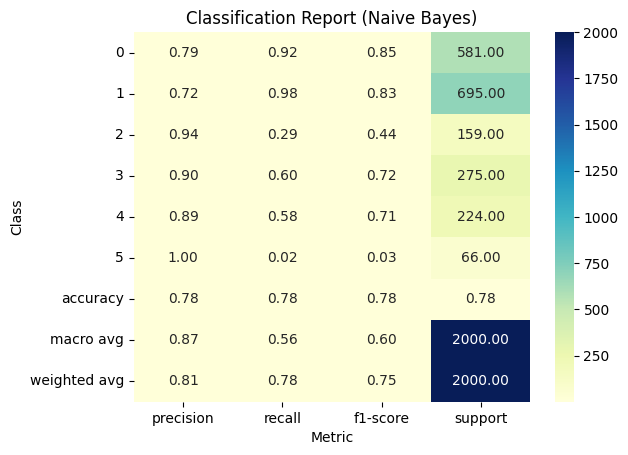

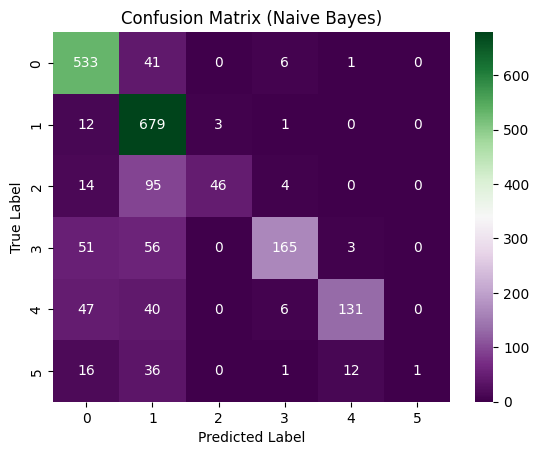

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a classification report
class_report_nb = classification_report(test_labels, y_test_pred_NB, output_dict=True)

# Convert the report to a DataFrame for better visualization
class_report_df_nb = pd.DataFrame(class_report_nb).transpose()

# Visualize the classification report
sns.heatmap(class_report_df_nb, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report (Naive Bayes)")
plt.xlabel("Metric")
plt.ylabel("Class")
plt.show()

# Create a confusion matrix
conf_matrix_nb = confusion_matrix(test_labels, y_test_pred_NB)

# Visualize the confusion matrix
sns.heatmap(conf_matrix_nb, annot=True, cmap="PRGn", fmt="d")
plt.title("Confusion Matrix (Naive Bayes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

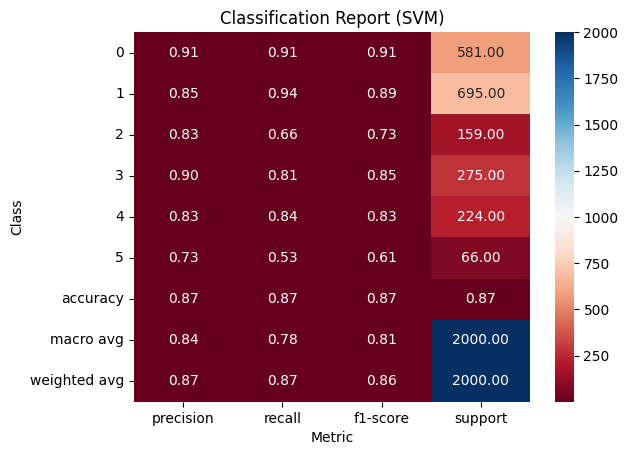

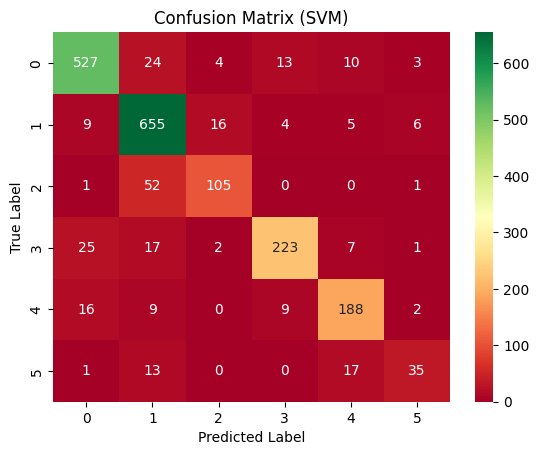

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a classification report
class_report_svm = classification_report(test_labels, y_test_pred_SVM, output_dict=True)

# Convert the report to a DataFrame for better visualization
class_report_df_svm = pd.DataFrame(class_report_svm).transpose()

# Visualize the classification report
sns.heatmap(class_report_df_svm, annot=True, cmap="RdBu", fmt=".2f")
plt.title("Classification Report (SVM)")
plt.xlabel("Metric")
plt.ylabel("Class")
plt.show()

# Create a confusion matrix
conf_matrix_svm = confusion_matrix(test_labels, y_test_pred_SVM)

# Visualize the confusion matrix
sns.heatmap(conf_matrix_svm, annot=True, cmap="RdYlGn", fmt="d")
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()